<a href="https://www.kaggle.com/code/sharabhojha/chord-generation-lstm-example?scriptVersionId=224328236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
!pip install liac-arff

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=61fad0ae58c51999159e6ae69590ee4f6372d1ae9128d18fe4bdb8cb9c91091a
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


In [2]:
# Preprocessing steps:
# 1: condense onset files to just onset times and onset notes

import os
import re
import pandas as pd
import arff

# Directory path to your annotations folder
annotations_dir = "/kaggle/input/aam-annotations/AAM-annotations/"
num = 0

# Iterate through all files in the directory
for filename in os.listdir(annotations_dir):
    if "onsets" in filename and filename.endswith(".arff"):  # Ensure it's an ARFF file with 'onsets' in its name
        num += 1
        file_path = os.path.join(annotations_dir, filename)
        
        # Read the ARFF file
        def read_arff(file_path):
            with open(file_path, 'r') as f:
                arff_data = arff.load(f)
            return pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
        
        # Use this function instead of manual parsing
        df = read_arff(file_path)

        # Convert numeric columns where possible
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])  # Convert if possible
            except ValueError:
                pass  # Keep as string if conversion fails

        all_onsets = []

        # Vectorized operation to collect all onset events
        df.drop(columns=["Onset events of Drums"], inplace=True)
        onset_columns = df.columns[df.apply(lambda col: col.astype(str).str.contains(r"\[", regex=True)).any()]
        df["Onset events"] = df[onset_columns].apply(lambda row: [int(x) for x in re.findall(r'\d+', ''.join(row.astype(str)))], axis=1)
        df.drop(onset_columns, axis=1, inplace=True)

        # Save the processed DataFrame to a new CSV file
        output_file = re.search("(\d+)", filename).group(0) + "_onset_condensed.csv"
        df.to_csv(output_file, index=False)

        if num % 100 == 0:
            print(f"Processed {filename} and saved to {output_file}")

Processed 0521_onsets.arff and saved to 0521_onset_condensed.csv
Processed 2699_onsets.arff and saved to 2699_onset_condensed.csv
Processed 2634_onsets.arff and saved to 2634_onset_condensed.csv
Processed 0544_onsets.arff and saved to 0544_onset_condensed.csv
Processed 1658_onsets.arff and saved to 1658_onset_condensed.csv
Processed 1624_onsets.arff and saved to 1624_onset_condensed.csv
Processed 1192_onsets.arff and saved to 1192_onset_condensed.csv
Processed 0001_onsets.arff and saved to 0001_onset_condensed.csv
Processed 0382_onsets.arff and saved to 0382_onset_condensed.csv
Processed 1000_onsets.arff and saved to 1000_onset_condensed.csv
Processed 0541_onsets.arff and saved to 0541_onset_condensed.csv
Processed 1630_onsets.arff and saved to 1630_onset_condensed.csv
Processed 0696_onsets.arff and saved to 0696_onset_condensed.csv
Processed 0121_onsets.arff and saved to 0121_onset_condensed.csv
Processed 0097_onsets.arff and saved to 0097_onset_condensed.csv
Processed 0220_onsets.arf

In [3]:
# 2: encode chord names and replace said chord names with encodings in beatinfo files

# Directory path to your annotations folder
headers = ['Start time in seconds', 'Bar count', 'Quarter count', 'Chord name']

chord_encodings = {0: 'A#maj', 1: 'A#min', 2: 'Amaj', 3: 'Amin', 4: 'Bmaj', 5: 'Bmin', 6: 'C#maj', 7: 'C#min', 
                   8: 'Cmaj', 9: 'Cmin', 10: 'D#maj', 11: 'D#min', 12: 'Dmaj', 13: 'Dmin', 14: 'Emaj', 15: 'Emin', 
                   16: 'F#maj', 17: 'F#min', 18: 'Fmaj', 19: 'Fmin', 20: 'G#maj', 21: 'G#min', 22: 'Gmaj', 
                   23: 'Gmin', 24: 'N.C.'}

inverted_encodings = {'A#maj': 0, 'A#min': 1, 'Amaj': 2, 'Amin': 3, 'Bmaj': 4, 'Bmin': 5, 'C#maj': 6, 'C#min': 7, 
                   'Cmaj': 8, 'Cmin': 9, 'D#maj': 10, 'D#min': 11, 'Dmaj': 12, 'Dmin': 13, 'Emaj': 14, 'Emin': 15, 
                   'F#maj': 16, 'F#min': 17, 'Fmaj': 18, 'Fmin': 19, 'G#maj': 20, 'G#min': 21, 'Gmaj': 22, 
                   'Gmin': 23, 'N.C.': 24}

# Iterate through all files in the directory
for filename in os.listdir(annotations_dir):
    if "beatinfo" in filename and filename.endswith(".arff"):  # Ensure it's an ARFF file with 'beatinfo' in its name
        file_path = os.path.join(annotations_dir, filename)
        df = pd.read_csv(file_path, comment='@', header=None)
        df.columns = headers

        for i in range(df.index.size):
            df.iat[i, 3] = df.iat[i, 3].replace("'", "")
            if df.iat[i, 3] == "BASS_NOTE_EXCEPTION":
                df.iat[i, 3] = "N.C."
            df.iat[i, 3] = inverted_encodings[df.iat[i, 3]]
    
        df.to_csv(filename.replace('arff', 'csv'), index=False)

In [4]:
# visualize the files
working_dir = "/kaggle/working/"
onsets = pd.read_csv(working_dir + "0001_onset_condensed.csv")
print(onsets.head())
beatinfo = pd.read_csv(working_dir + "0001_beatinfo.csv")
print(beatinfo.head())

def align_onsets_with_chords(onsets, beatinfo):
    aligned_data = []
    for _, onset_row in onsets.iterrows():
        onset_time = onset_row['Onset time in seconds']
        # Find the chord corresponding to this onset time
        chord_row = beatinfo[beatinfo['Start time in seconds'] <= onset_time].iloc[-1]
        onset_list = eval(onset_row['Onset events'])
        if chord_row['Chord name'] != 24 and len(onset_list) > 0:
            aligned_data.append((onset_list, chord_row['Chord name']))
    return aligned_data

   Onset time in seconds  Onset events
0               0.000000  [41, 60, 65]
1               0.326086      [41, 60]
2               0.652173  [41, 65, 65]
3               0.978259  [41, 65, 69]
4               1.304346  [41, 65, 65]
   Start time in seconds  Bar count  Quarter count  Chord name
0               0.000000          1              1          18
1               0.652174          1              2          18
2               1.304348          1              3          18
3               1.956522          1              4          18
4               2.608696          2              1           0


In [5]:
# create aligned data for every onset and beatinfo file

all_data = []
i = 0

while i < 3000:
    i += 1
    onset_path = os.path.join(working_dir, f"{i :04d}_onset_condensed.csv")
    beatinfo_path = os.path.join(working_dir, f"{i :04d}_beatinfo.csv")
    onsets = pd.read_csv(onset_path)
    beatinfo = pd.read_csv(beatinfo_path)
    all_data.append(align_onsets_with_chords(onsets, beatinfo))

print(len(all_data))
#print(all_data[0:20])

3000


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

def create_chord_classification_model(vocab_size, embedding_dim, lstm_units, num_classes, max_sequence_length):
    # Input for note sequences
    note_input = Input(shape=(max_sequence_length,))
    
    # Embedding layer for note sequences
    note_embedding = Embedding(vocab_size, embedding_dim)(note_input)
    
    # LSTM layers
    lstm_output = LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(note_embedding) # with more lstm layers, return sequences = true
    lstm_output = BatchNormalization()(lstm_output)
    lstm_output = LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(lstm_output)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(lstm_output)
    
    model = Model(inputs=note_input, outputs=output)
    return model

# Hyperparameters
vocab_size = 128  # Assuming MIDI note range
embedding_dim = 64
lstm_units = 64
num_classes = 24  # Number of chord classes
max_sequence_length = 16  # Adjust based on your data

# Create the model
model = create_chord_classification_model(vocab_size, embedding_dim, lstm_units, num_classes, max_sequence_length)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Split at the song level (here I can decide how many of the songs I want to use)
train_songs, test_songs = train_test_split(all_data[0:60], test_size=0.2, random_state=42)

# Flatten sequences within each split
train_data = [pair for song in train_songs for pair in song]  # Keep full song sequences together
test_data = [pair for song in test_songs for pair in song]

print(f"Total training sequences: {len(train_data)}")
print(f"Total testing sequences: {len(test_data)}")

# Function to prepare data
def prepare_data(data, max_sequence_length):
    X, y = [], []
    for notes, chord in data:
        padded_notes = tf.keras.preprocessing.sequence.pad_sequences([notes], maxlen=max_sequence_length, padding='post', truncating='post')[0]
        X.append(padded_notes)
        y.append(chord)
    return np.array(X), np.array(y)

# Prepare train and test data
X_train, y_train = prepare_data(train_data, max_sequence_length)
X_test, y_test = prepare_data(test_data, max_sequence_length)

# Convert y to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
model_save = ModelCheckpoint('checkpoint.model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

model.save('BestChordPredictor.keras')

# Function for inference
def predict_chord(model, note_sequence):
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([note_sequence], maxlen=max_sequence_length, padding='post', truncating='post')
    predictions = model.predict(padded_sequence)
    return np.argmax(predictions[0])  # Return the prediction

# Example usage
sample_sequence = [60, 64, 67, 72]  # C major chor
predicted_chord = predict_chord(model, sample_sequence)
print(f"Predicted chord num: {predicted_chord}")
print(f"Predicted chord: {chord_encodings[predicted_chord]}")

Total training sequences: 28773
Total testing sequences: 5915
Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1627 - loss: 3.2200 - val_accuracy: 0.6563 - val_loss: 1.6785 - learning_rate: 1.0000e-04
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5929 - loss: 1.8095 - val_accuracy: 0.7692 - val_loss: 1.3549 - learning_rate: 1.0000e-04
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.6928 - loss: 1.5312 - val_accuracy: 0.8019 - val_loss: 1.2548 - learning_rate: 1.0000e-04
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.7273 - loss: 1.4052 - val_accuracy: 0.8103 - val_loss: 1.1884 - learning_rate: 1.0000e-04
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.7518 - loss: 1.3222 - val_accuracy: 0.8147 - val_loss: 1.1319 - learning_rate: 1.0000e-04
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.7674 - loss: 1.2624 - val_accuracy: 0.8140 - val_loss: 1.1058 - learning_r

In [7]:
chords = {
    "C Major": [60, 64, 67, 72],
    "C Minor": [60, 63, 67, 72],
    
    "C# Major / Db Major": [61, 65, 68, 73],
    "C# Minor / Db Minor": [61, 64, 68, 73],
    
    "D Major": [62, 66, 69, 74],
    "D Minor": [62, 65, 69, 74],
    
    "D# Major / Eb Major": [63, 67, 70, 75],
    "D# Minor / Eb Minor": [63, 66, 70, 75],
    
    "E Major": [64, 68, 71, 76],
    "E Minor": [64, 67, 71, 76],
    
    "F Major": [65, 69, 72, 77],
    "F Minor": [65, 68, 72, 77],
    
    "F# Major / Gb Major": [66, 70, 73, 78],
    "F# Minor / Gb Minor": [66, 69, 73, 78],
    
    "G Major": [67, 71, 74, 79],
    "G Minor": [67, 70, 74, 79],
    
    "G# Major / Ab Major": [68, 72, 75, 80],
    "G# Minor / Ab Minor": [68, 71, 75, 80],
    
    "A Major": [69, 73, 76, 81],
    "A Minor": [69, 72, 76, 81],
    
    "A# Major / Bb Major": [70, 74, 77, 82],
    "A# Minor / Bb Minor": [70, 73, 77, 82],
    
    "B Major": [71, 75, 78, 83],
    "B Minor": [71, 74, 78, 83]
}

for chord in chords.values():
    pred_chord = predict_chord(model, chord)
    print(chord_encodings[pred_chord])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Cmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Cmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
C#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
C#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Dmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Dmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
D#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
D#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Emaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Emin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
F#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
F#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
G#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
D#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
G#maj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
G#min
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Amaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Cmaj
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Gmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Gmin
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
G#min


In [8]:
from sklearn.metrics import confusion_matrix

#Predict
Y_prediction = model.predict(X_test)
Y_prediction = np.argmax (Y_prediction, axis = 1)
Y_test=np.argmax(y_test_onehot, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(Y_test, Y_prediction , normalize='pred')


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


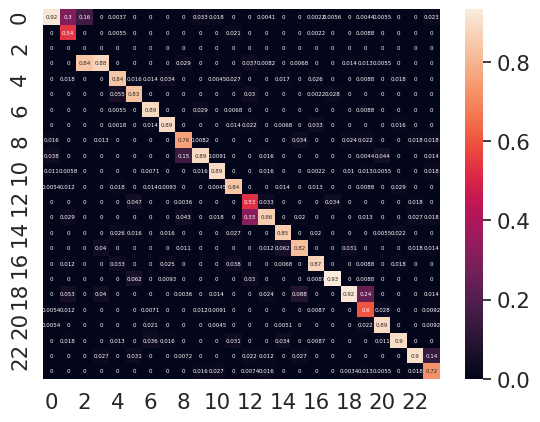

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(result, range(24), range(24))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 4}) # font size

plt.show()